In [1]:
import pickle
import os
import re
from wiki_utils import get_category_data
from network_utils import filter_graph_by_attribute, count_nodes_by_attribute
from sklearn.cluster import KMeans

DOWNLOADS_DIR = "downloads"
RANDOM_STATE = 42
# load graph:
S = pickle.load(open("graph.pkl", "rb"))
S_undirected = pickle.load(open("graph_undirected.pkl", "rb"))

# Extracting Communities from Wikipedia

## (A) Using `region` (Not used)

### Creating `S_region`
Finds region in wikitext downloaded and adds it to the network (if multiple exist it takes the first region)

In [2]:
S_subfields = S_undirected.copy()

region_pattern = r'\|\s*region\s*=\s*\[\[([^\]]+)\]\]'
nodes_to_remove = []  # Collect nodes to remove

for node in list(S_subfields.nodes):
	node_file_name = DOWNLOADS_DIR + "/" + node + ".txt"
	if os.path.exists(node_file_name):
		try:
			with open(node_file_name, 'r', encoding='utf-8') as f:
				text = f.read()
				matches = re.search(region_pattern, text)
				if matches:
					# Extract all individual regions from the matched string
					regions = re.findall(r'\[\[([^\]]+)\]\]', matches.group(0))
					S_subfields.nodes[node]['region'] = regions[0]
				else:
					nodes_to_remove.append(node)  # Mark node for removal
		except Exception as e:
			print(f"Error processing node {node}: {e}")
	else:
		nodes_to_remove.append(node)  # Mark node for removal if file does not exist
S_subfields.remove_nodes_from(nodes_to_remove)

In [3]:
print("Original graph: ", S)
print("Region graph: ", S_subfields)
print(list(S_subfields.nodes(data=True))[143])

Original graph:  DiGraph with 1366 nodes and 10864 edges
Region graph:  Graph with 557 nodes and 3526 edges
('Bernard_Delfgaauw', {'contentlength': 328, 'region': 'Western philosophy'})


### Generating the communities

In [4]:
region_partition = {}

for node, data in S_subfields.nodes(data=True):
		genre = data.get('region')
		if genre not in region_partition:
			region_partition[genre] = []
		region_partition[genre].append(node)

print("Region communities with length:")
for genre, nodes in region_partition.items():
		print(f"Region: {genre}, Length: {len(nodes)}")

Region communities with length:
Region: Western philosophy, Length: 496
Region: Chinese philosophy, Length: 6
Region: Byzantine Empire, Length: 1
Region: Islamic philosophy, Length: 3
Region: Middle Eastern philosophy, Length: 4
Region: Western Philosophy, Length: 3
Region: Africana philosophy, Length: 1
Region: British Unitarianism, Length: 1
Region: Russian philosophy, Length: 10
Region: Eastern philosophy, Length: 5
Region: Persia, Length: 2
Region: Spanish philosophy, Length: 1
Region: American philosophy, Length: 2
Region: African philosophy, Length: 1
Region: Indian philosophy, Length: 1
Region: Mithila region, Length: 1
Region: Teng (state)|Teng, Length: 1
Region: Japanese philosophy, Length: 1
Region: Safavid Persia, Length: 1
Region: Roman Egypt, Length: 1
Region: Greater Iran|Persia, Length: 1
Region: Austria, Length: 1
Region: Seljuq Empire, Length: 1
Region: Middle East, Length: 1
Region: Western philosophy|Western, Length: 1
Region: East Asian philosophy, Length: 1
Region:

Only western philosophy is the big one.

## (B) Using `subfield`
https://en.wikipedia.org/wiki/Lists_of_philosophers

### (B.1) Extracting subfield information

In [5]:
subfield_links = [
		"List of aestheticians",
		"List of critical theorists",
		"List of environmental philosophers",
		"List of epistemologists",
		"List of ethicists",
		"List of existentialists",
		"List of feminist philosophers",
		"List of secular humanists", #List of Humanists redirect
		"List of logicians",
		"List of metaphysicians",
		"Index of sociopolitical thinkers", #List of Social and Political Philosophers redirect
		"List of phenomenologists",
		"List of philosophers of language",
		"List of philosophers of mind",
		"List of philosophers of religion",
		"List of philosophers of science",
		"List of political philosophers",
		"List of political theorists",
		"List of rationalists",
		"List of utilitarians"
]

- Option 1: **Fetch the data from Wikipedia** (takes around 5 seconds)

In [6]:
replace_terms_subfields = [("List of", ""), ("Index of", "")]
clean_subfield_data, philosopher_subfield_info = get_category_data(
    subfield_links, replace_terms_subfields, verbose=True
)
pickle.dump(philosopher_subfield_info, open("philosopher_subfield_info.pkl", "wb")) # Saved as local version for later use

print("Total =", len(philosopher_subfield_info))

- aestheticians: 86
- critical theorists: 107
- environmental philosophers: 80
- epistemologists: 122
- ethicists: 287
- existentialists: 60
- feminist philosophers: 134
- secular humanists: 413
- logicians: 291
- metaphysicians: 185
- sociopolitical thinkers: 245
- phenomenologists: 24
- philosophers of language: 141
- philosophers of mind: 140
- philosophers of religion: 110
- philosophers of science: 111
- political philosophers: 199
- political theorists: 137
- rationalists: 27
- utilitarians: 104
Total = 2183


- Option 2: **Use local pickle file** from last time option 1 was run

In [7]:
philosopher_subfield_info = pickle.load(open("philosopher_subfield_info.pkl", "rb"))

### (B.2) Creating `S.subfields` network

In [8]:
S_subfields = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_subfield_info,
    attribute_name='subfields',
    verbose=True
)
print("-"*50)
count_nodes_by_attribute(S_subfields, 'subfields', verbose=True)
print("-"*50)


Did not find subfields for: 771 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['Pierre_Laffitte', 'Paul_Mattick', 'Boetius_of_Dacia']
Original graph: 1366 nodes and 9026 edges
Filtered 'subfields' graph: 595 nodes and 4233 edges
--------------------------------------------------
Number of nodes by subfields:
 -> secular humanists: 34
 -> philosophers of science: 45
 -> political philosophers: 135
 -> political theorists: 73
 -> aestheticians: 51
 -> ethicists: 115
 -> philosophers of language: 68
 -> critical theorists: 41
 -> epistemologists: 78
 -> sociopolitical thinkers: 131
 -> philosophers of mind: 57
 -> logicians: 89
 -> metaphysicians: 119
 -> philosophers of religion: 49
 -> utilitarians: 29
 -> phenomenologists: 11
 -> feminist philosophers: 23
 -> rationalists: 17
 -> environmental philosophers: 8
 -> existentialists: 7
--------------------------------------------------


## (C) Using `tradition` (western/eastern divide)

### (C.1) Extracting information from wikipedia

- Option 1: Extract from wikipedia

In [9]:
tradition_links = [
	"Timeline of Eastern philosophers",
	"Timeline of Western philosophers"
]

replace_terms_traditions = [("Timeline of", "")]
clean_tradition_data, philosopher_tradition_info = get_category_data(
    tradition_links, replace_terms_traditions, verbose=True
)
pickle.dump(philosopher_tradition_info, open("philosopher_tradition_info.pkl", "wb")) # Saved as local version for later use
print("Total =", len(philosopher_tradition_info))

- Eastern philosophers: 343
- Western philosophers: 565
Total = 893


- Option 2: **Use local pickle file** from last time option 1 was run

In [10]:
philosopher_tradition_info = pickle.load(open("philosopher_tradition_info.pkl", "rb"))

### (C.2) Creating `S_tradition` network

In [11]:
S_tradition = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_tradition_info,
    attribute_name='tradition',
    verbose=True
)

print("-"*50)
count_nodes_by_attribute(S_tradition, 'tradition', verbose=True)
print("-"*50)

Did not find tradition for: 1020 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['Niels_Bohr', 'Thomas_Paine', 'Pierre_Laffitte']
Original graph: 1366 nodes and 9026 edges
Filtered 'tradition' graph: 346 nodes and 2561 edges
--------------------------------------------------
Number of nodes by tradition:
 -> Western philosophers: 279
 -> Eastern philosophers: 69
--------------------------------------------------


# Partitioning

## Imports and definitions

In [12]:
# Install community package if not already installed
#%pip install python-louvain

In [13]:
from community import community_louvain
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans

def create_partition_using_attribute(graph, attribute_name):
	partition = {}
	for node, data in graph.nodes(data=True):
		attribute = data.get(attribute_name)
		if isinstance(attribute, list):
			attribute = attribute[0]
		if attribute is not None:
				partition[node] = attribute
	return partition

def get_louvain_modularity(graph, partition_dict):
	return f"{community_louvain.modularity(partition_dict, graph):.4f}"

def plot_partition_heatmap(graph, attribute_partition, louvain_partition, attribute_name, top_n=7, title="Confusion Matrix"):
    """
    Plots a confusion matrix heatmap comparing attribute-based partition and Louvain community partition.

    Args:
        graph (networkx.Graph): The graph to analyze.
        attribute_partition (dict): Partition mapping nodes to their attributes.
        louvain_partition (dict): Louvain partition mapping nodes to communities.
        attribute_name (str): Name of the attribute (e.g., 'subfields' or 'tradition').
        top_n (int): Number of top attributes and communities to consider for the heatmap.
        title (str): Title of the heatmap.
    """
    # Step 1: Identify top attributes and communities
    attribute_counts = Counter(attribute_partition.values())
    top_attributes = [attribute for attribute, _ in attribute_counts.most_common(top_n)]

    community_counts = Counter(louvain_partition.values())
    top_communities = [community for community, _ in community_counts.most_common(top_n)]

    # Step 2: Map attributes and communities to matrix indices
    attribute_to_index = {attribute: idx for idx, attribute in enumerate(top_attributes)}
    community_to_index = {community: idx for idx, community in enumerate(top_communities)}

    # Step 3: Initialize confusion matrix D
    D = np.zeros((top_n, top_n), dtype=int)

    # Step 4: Populate the confusion matrix
    for node in graph.nodes:
        attribute = attribute_partition.get(node)  # Get node's attribute
        community = louvain_partition.get(node)  # Get node's Louvain community

        # Only consider top attributes and communities
        if community in community_to_index and attribute in attribute_to_index:
            i = attribute_to_index[attribute]
            j = community_to_index[community]
            D[i, j] += 1

    # Step 5: Create the heatmap
    plt.figure(figsize=(7, 7))
    plt.imshow(D, interpolation='nearest', cmap='Blues')

    # Add text annotations for each cell
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            plt.text(j, i, int(D[i, j]), ha="center", va="center", color="black")

    # Add titles, labels, and ticks
    plt.title(title)
    plt.xlabel('Communities')
    plt.ylabel(f'{attribute_name.capitalize()}')

    # Set tick labels
    plt.xticks(np.arange(len(top_communities)), [f"C {c}" for c in top_communities])
    plt.yticks(np.arange(len(top_attributes)), top_attributes)

    # Add a color bar
    plt.colorbar()
    plt.show()
    

# def louvain_kmeans_partition(graph, num_clusters, use_adjacency=True):
#     """
#     Runs Louvain community detection, creates a feature matrix, and reclusters nodes into a specified number of communities using k-means.
    
#     Args:
#         graph (networkx.Graph): The input graph.
#         num_clusters (int): Desired number of communities for k-means clustering.
#         random_state (int): Random seed for reproducibility.
#         use_adjacency (bool): Whether to use the adjacency matrix as the feature matrix.
        
#     Returns:
#         dict: A dictionary mapping nodes to their new community labels.
#     """
#     # Step 1: Run Louvain community detection
#     louvain_partition = community_louvain.best_partition(graph)
    
#     # Step 2: Create a feature matrix
#     nodes = list(graph.nodes())
#     if use_adjacency:
#         # Use adjacency matrix as feature matrix
#         feature_matrix = nx.to_numpy_array(graph)
#     else:
#         # Use Louvain partition as a feature (one-hot encoded)
#         louvain_features = np.zeros((len(nodes), max(louvain_partition.values()) + 1))
#         for i, node in enumerate(nodes):
#             louvain_features[i, louvain_partition[node]] = 1
#         feature_matrix = louvain_features

#     # Step 3: Run k-means clustering
#     kmeans = KMeans(n_clusters=num_clusters, random_state=RANDOM_STATE, n_init=10)
#     labels = kmeans.fit_predict(feature_matrix)

#     # Step 4: Map nodes to new communities
#     new_partition = {nodes[i]: labels[i] for i in range(len(nodes))}
    
#     return new_partition

## `S_subfields`

Each node is characterized by the first `subfield` if there are multiple.

In [14]:
subfields_partition = create_partition_using_attribute(S_subfields, 'subfields')
subfields_partition_modularity = get_louvain_modularity(S_subfields, subfields_partition)
print("Subfields partion Modularity = ", subfields_partition_modularity)

louvain_partition_S_subfields = community_louvain.best_partition(S_subfields, random_state=RANDOM_STATE)
print("Louvain partion Modularity = ", get_louvain_modularity(S_subfields, louvain_partition_S_subfields))

# louvain_partition_S_subfields_kmeans = louvain_kmeans_partition(S_subfields, len(subfield_links))
# print("Louvain partion (with KMeans community limit) Modularity = ", get_louvain_modularity(S_subfields, louvain_partition_S_subfields_kmeans))

Subfields partion Modularity =  0.0869
Louvain partion Modularity =  0.4184


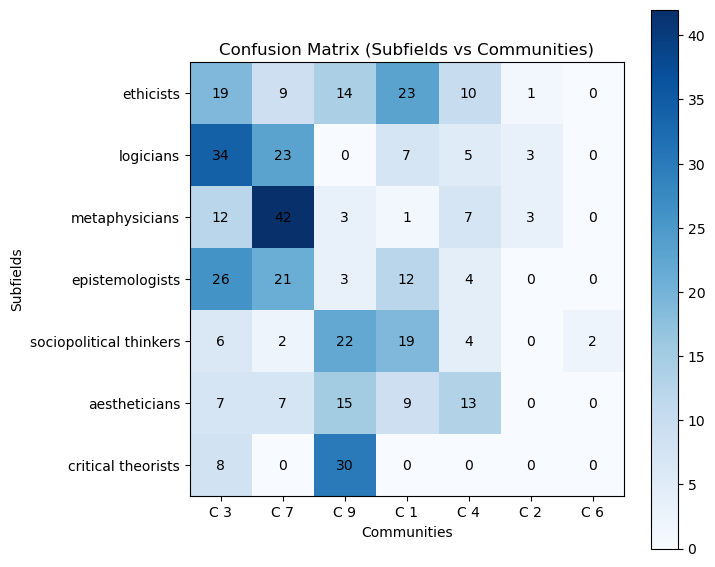

In [15]:
plot_partition_heatmap(
    graph=S_subfields,
    attribute_partition=subfields_partition,
    louvain_partition=louvain_partition_S_subfields,
    attribute_name='subfields',
    title='Confusion Matrix (Subfields vs Communities)'
)

## `S_tradition`

In [16]:
tradition_partition = create_partition_using_attribute(S_tradition, 'tradition')
tradition_partition_modularity = get_louvain_modularity(S_tradition, tradition_partition)

print("Tradition partion Modularity = ", tradition_partition_modularity)

louvain_partition_S_tradition = community_louvain.best_partition(S_tradition, random_state=RANDOM_STATE)
print("Louvain partion Modularity = ", get_louvain_modularity(S_tradition, louvain_partition_S_tradition))

# louvain_partition_S_tradition_kmeans = louvain_kmeans_partition(S_tradition, 2)
# print("Louvain partion (with KMeans community limit) Modularity = ", get_louvain_modularity(S_tradition, louvain_partition_S_tradition_kmeans))

Tradition partion Modularity =  0.0802
Louvain partion Modularity =  0.3972


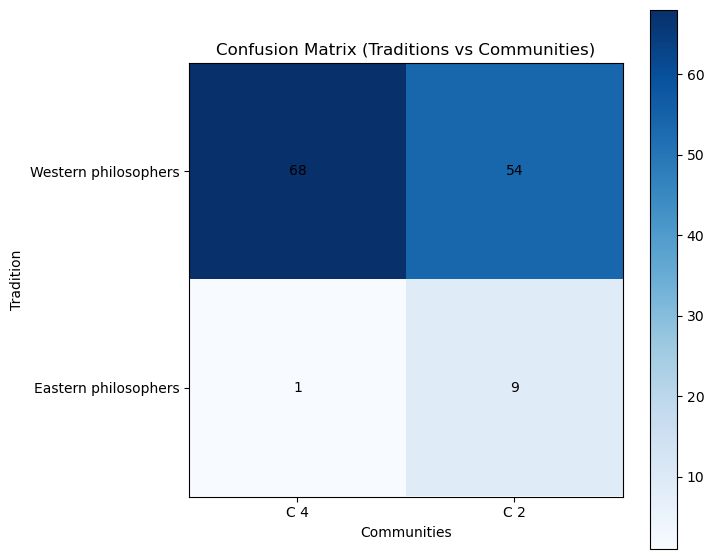

In [17]:
plot_partition_heatmap(
    graph=S_tradition,
    attribute_partition=tradition_partition,
    louvain_partition=louvain_partition_S_tradition,
    attribute_name='tradition',
    top_n=2,
	title='Confusion Matrix (Traditions vs Communities)'
)

In [18]:
import pickle

# Save subfields and Louvain partitions
with open("subfields_partition.pkl", "wb") as file:
    pickle.dump(subfields_partition, file)

with open("louvain_partition_subfields.pkl", "wb") as file:
    pickle.dump(louvain_partition_S_subfields, file)

# Save tradition and Louvain partitions
with open("tradition_partition.pkl", "wb") as file:
    pickle.dump(tradition_partition, file)

with open("louvain_partition_tradition.pkl", "wb") as file:
    pickle.dump(louvain_partition_S_tradition, file)

print("Community partitions saved successfully!")

Community partitions saved successfully!
